Modeling: Multiple Linear Regression, Support Vector Machine, Neural Network

In [1]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import datetime
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in data: 
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

X_train.index = X_train['Unnamed: 0']
X_train = X_train.drop(['Unnamed: 0'], axis=1)
X_test.index = X_test['Unnamed: 0']
X_test = X_test.drop(['Unnamed: 0'], axis=1)
y_train.index = y_train['Unnamed: 0']
y_train = y_train.drop(['Unnamed: 0'], axis=1)
y_test.index = y_test['Unnamed: 0']
y_test = y_test.drop(['Unnamed: 0'], axis=1)
print(X_train.head(3))

            Epoch Time  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
Unnamed: 0                                                               
8415          1.596577         0.022370     0.137012          2.092940   
5049          0.262704         0.838222     1.359982         -0.029683   
8395          1.588654        -0.145847    -0.596770         -0.319131   

            Visibility (10m)  Dew point temperature(°C)  \
Unnamed: 0                                                
8415               -1.176113                   0.130553   
5049               -1.472667                   1.255469   
8395               -0.930350                  -0.316331   

            Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  \
Unnamed: 0                                                         
8415                       0.519701     -0.134019      -0.171026   
5049                       0.210677     -0.134019      -0.171026   
8395                      -0.659168     -0.134019      -0.171

In [3]:
# first model with an arbitrary choice of n_features
# running RFE with number of features=10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=10)             
rfe = rfe.fit(X_train, y_train)

# predict counts of X_test
y_pred = rfe.predict(X_test)

# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.46495444931681296


In [6]:
# try with another value of RFE
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=6)             
rfe = rfe.fit(X_train, y_train)

# predict count of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print("R-squared: ", r2)

# k-fold CV (using all the 13 variables)
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
print("R-squared: ", scores)

# Tune other metrics, such as MSE
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
print("neg_mean_squared_error: ", scores)

R-squared:  0.45044607085019395
R-squared:  [0.43170268 0.46053917 0.48053857 0.46526408 0.46554122]
neg_mean_squared_error:  [-0.55155564 -0.53215395 -0.54209596 -0.54275795 -0.52461776]


Number of features:  13
Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    1.2s finished


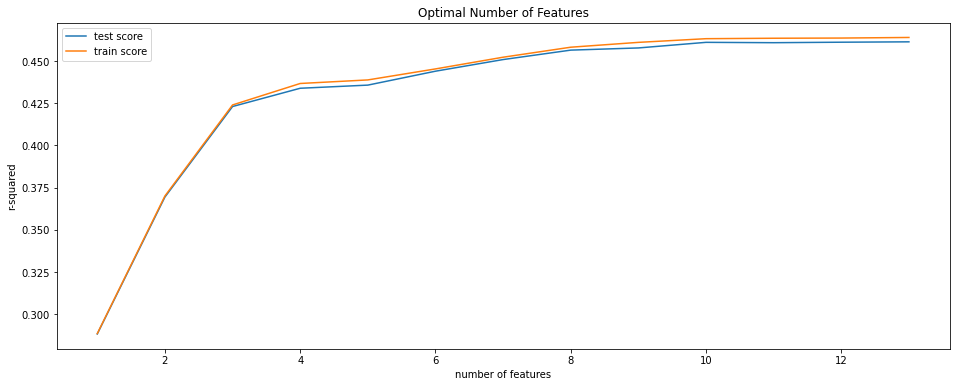

In [7]:
# Hyperparameter Tuning Using Grid Search Cross-Validation
# number of features in X_train
print("Number of features: ", len(X_train.columns))

# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 14))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train) 

# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

# plotting cv results
plt.figure(figsize=(16,6))
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left');

In [8]:
# final model for Multiple Linear Regression
n_features_optimal = 10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict counts of X_test
y_pred = lm.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.4661303446979901


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


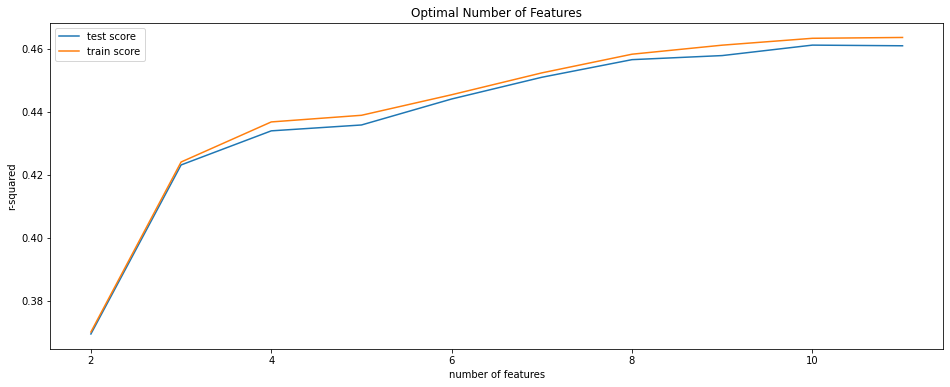

In [10]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 12))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left');

In [11]:
# Support Vector Machine Regression
from sklearn.svm import SVR

X = X_train
y = y_train

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

In [9]:
svr_lin = SVR(kernel='linear', C=1e3)

In [10]:
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

In [11]:
y_rbf = svr_rbf.fit(X, y).predict(X) #Takes a minute or two

In [11]:
y_lin = svr_lin.fit(X, y).predict(X) #Takes 20 minutes

In [12]:
y_poly = svr_poly.fit(X, y).predict(X)

In [12]:
#from sklearn.grid_search import GridSearchCV
#param_grid = {'svc__C': [1, 5, 10, 50],
             # 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
#grid = GridSearchCV(model, param_grid)

#%time grid.fit(X_train, y_train)
#print(grid.best_params_)

from sklearn.svm import SVR
from sklearn.model_selection import learning_curve, GridSearchCV
#from sklearn.model_selection import GridSearchCV
#param_grid = { 'C':[0.1,1,100,1000],'kernel':['rbf','poly','sigmoid','linear'],'degree':[1,2,3,4,5,6],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
param_grid = { 'C':[0.1, 10, 100],'kernel':['rbf'],'gamma': [1, 0.1, 0.01], 'epsilon': [0.1]}
grid = GridSearchCV(SVR(),param_grid)
grid.fit(X_train,y_train)

#svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 10, 100], 'epsilon': [0.1],
                         'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']})

In [13]:
print(grid.best_params_)

print(grid.score(X_test,y_test))

{'C': 100, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.6867527081844389


In [14]:
# predict counts of X_test
y_pred = grid.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.6867527081844389


Neural Network Model

In [15]:
# Neural networks model (Multi-Layer Perceptron Classifier model)
import sys
sys.path.append('/Users/elinorvelasquez/anaconda3/lib/python3.8/site-packages/')
#!conda install -c conda-forge nltk

import sklearn
import nltk

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
# For neural networks, > 0.18 is needed. I have 0.23.2.

The nltk version is 3.6.1.
The scikit-learn version is 0.23.2.


In [16]:
# The neural network in Python may have difficulty converging before the maximum number of iterations allowed 
# if the data is not normalized. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
X_train = scaler.fit_transform(X_train)
# Now apply the transformations to the test data
X_test = scaler.transform(X_test)

In [17]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=50)

y_train1 = y_train.astype('int')
mlp.fit(X_train, np.ravel(y_train1))
predictions = mlp.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix
y_test1 = y_test.astype('int')

print(confusion_matrix(y_test1, predictions))
print(classification_report(y_test1, predictions))
print(len(mlp.coefs_))
print(len(mlp.coefs_[0]))
print(len(mlp.intercepts_[0]))

[[  87   61    0    0    0    0]
 [  17 1283   11    1    0    0]
 [   0  168   19   11    0    0]
 [   0   58   16    9    0    0]
 [   0    3    3    2    0    0]
 [   0    1    1    1    0    0]]
              precision    recall  f1-score   support

          -1       0.84      0.59      0.69       148
           0       0.82      0.98      0.89      1312
           1       0.38      0.10      0.15       198
           2       0.38      0.11      0.17        83
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         3

    accuracy                           0.80      1752
   macro avg       0.40      0.30      0.32      1752
weighted avg       0.74      0.80      0.75      1752

4
13
13


# CatBoostRegressor

In [19]:
import sys
sys.path.append('/Users/elinorvelasquez/anaconda3/lib/python3.8/site-packages/')
#!conda install -c conda-forge bayesian-optimization
#!conda install -c conda-forge lightgbm
#!conda install -c conda-forge catboost

import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

In [18]:
#train_dataset = cb.Pool(X_train, y_train) 
#test_dataset = cb.Pool(X_test, y_test)

In [21]:
model = cb.CatBoostRegressor()
model2 = model.fit(X_train, y_train)
pred = model2.predict(X_test)

# Metrics
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('r2: ', r2)
print('rmse: ', rmse)

Learning rate set to 0.055197
0:	learn: 0.9738112	total: 2.99ms	remaining: 2.99s
1:	learn: 0.9496108	total: 5.21ms	remaining: 2.6s
2:	learn: 0.9267818	total: 7.04ms	remaining: 2.34s
3:	learn: 0.9068017	total: 9.13ms	remaining: 2.27s
4:	learn: 0.8879385	total: 10.9ms	remaining: 2.16s
5:	learn: 0.8699223	total: 12.9ms	remaining: 2.13s
6:	learn: 0.8518442	total: 15ms	remaining: 2.12s
7:	learn: 0.8359871	total: 16.7ms	remaining: 2.07s
8:	learn: 0.8212183	total: 18.4ms	remaining: 2.03s
9:	learn: 0.8082223	total: 20.5ms	remaining: 2.03s
10:	learn: 0.7955623	total: 22.2ms	remaining: 1.99s
11:	learn: 0.7845464	total: 23.7ms	remaining: 1.95s
12:	learn: 0.7722740	total: 25.4ms	remaining: 1.93s
13:	learn: 0.7608516	total: 27ms	remaining: 1.9s
14:	learn: 0.7515072	total: 28.7ms	remaining: 1.88s
15:	learn: 0.7418447	total: 30.2ms	remaining: 1.86s
16:	learn: 0.7326733	total: 31.8ms	remaining: 1.84s
17:	learn: 0.7241856	total: 33.6ms	remaining: 1.83s
18:	learn: 0.7158718	total: 35.3ms	remaining: 1.82

221:	learn: 0.4886488	total: 354ms	remaining: 1.24s
222:	learn: 0.4882475	total: 356ms	remaining: 1.24s
223:	learn: 0.4879481	total: 357ms	remaining: 1.24s
224:	learn: 0.4873557	total: 359ms	remaining: 1.24s
225:	learn: 0.4870033	total: 360ms	remaining: 1.23s
226:	learn: 0.4867787	total: 362ms	remaining: 1.23s
227:	learn: 0.4863898	total: 363ms	remaining: 1.23s
228:	learn: 0.4861133	total: 365ms	remaining: 1.23s
229:	learn: 0.4857295	total: 366ms	remaining: 1.23s
230:	learn: 0.4853856	total: 368ms	remaining: 1.23s
231:	learn: 0.4851766	total: 370ms	remaining: 1.22s
232:	learn: 0.4849285	total: 371ms	remaining: 1.22s
233:	learn: 0.4844447	total: 373ms	remaining: 1.22s
234:	learn: 0.4841330	total: 376ms	remaining: 1.22s
235:	learn: 0.4836305	total: 378ms	remaining: 1.22s
236:	learn: 0.4832988	total: 380ms	remaining: 1.22s
237:	learn: 0.4830220	total: 382ms	remaining: 1.22s
238:	learn: 0.4827376	total: 384ms	remaining: 1.22s
239:	learn: 0.4824093	total: 386ms	remaining: 1.22s
240:	learn: 

417:	learn: 0.4369575	total: 706ms	remaining: 982ms
418:	learn: 0.4368036	total: 707ms	remaining: 981ms
419:	learn: 0.4366345	total: 709ms	remaining: 979ms
420:	learn: 0.4363888	total: 710ms	remaining: 977ms
421:	learn: 0.4362841	total: 712ms	remaining: 975ms
422:	learn: 0.4360975	total: 714ms	remaining: 974ms
423:	learn: 0.4359609	total: 715ms	remaining: 972ms
424:	learn: 0.4357806	total: 717ms	remaining: 970ms
425:	learn: 0.4354855	total: 718ms	remaining: 968ms
426:	learn: 0.4354828	total: 720ms	remaining: 966ms
427:	learn: 0.4351182	total: 721ms	remaining: 964ms
428:	learn: 0.4349222	total: 723ms	remaining: 962ms
429:	learn: 0.4346564	total: 725ms	remaining: 961ms
430:	learn: 0.4345584	total: 727ms	remaining: 959ms
431:	learn: 0.4344667	total: 729ms	remaining: 958ms
432:	learn: 0.4344637	total: 731ms	remaining: 957ms
433:	learn: 0.4344610	total: 733ms	remaining: 955ms
434:	learn: 0.4342585	total: 734ms	remaining: 953ms
435:	learn: 0.4341066	total: 736ms	remaining: 952ms
436:	learn: 

607:	learn: 0.4047295	total: 1.06s	remaining: 682ms
608:	learn: 0.4046140	total: 1.06s	remaining: 680ms
609:	learn: 0.4045388	total: 1.06s	remaining: 678ms
610:	learn: 0.4043166	total: 1.06s	remaining: 677ms
611:	learn: 0.4042032	total: 1.06s	remaining: 675ms
612:	learn: 0.4040817	total: 1.07s	remaining: 673ms
613:	learn: 0.4039521	total: 1.07s	remaining: 672ms
614:	learn: 0.4037871	total: 1.07s	remaining: 670ms
615:	learn: 0.4034759	total: 1.07s	remaining: 668ms
616:	learn: 0.4033523	total: 1.07s	remaining: 667ms
617:	learn: 0.4031346	total: 1.07s	remaining: 665ms
618:	learn: 0.4029269	total: 1.08s	remaining: 663ms
619:	learn: 0.4027932	total: 1.08s	remaining: 662ms
620:	learn: 0.4025769	total: 1.08s	remaining: 660ms
621:	learn: 0.4024955	total: 1.08s	remaining: 659ms
622:	learn: 0.4023447	total: 1.09s	remaining: 657ms
623:	learn: 0.4022552	total: 1.09s	remaining: 656ms
624:	learn: 0.4020532	total: 1.09s	remaining: 654ms
625:	learn: 0.4019109	total: 1.09s	remaining: 652ms
626:	learn: 

807:	learn: 0.3768061	total: 1.41s	remaining: 335ms
808:	learn: 0.3767517	total: 1.41s	remaining: 334ms
809:	learn: 0.3766009	total: 1.42s	remaining: 332ms
810:	learn: 0.3764493	total: 1.42s	remaining: 330ms
811:	learn: 0.3763102	total: 1.42s	remaining: 328ms
812:	learn: 0.3761756	total: 1.42s	remaining: 327ms
813:	learn: 0.3760663	total: 1.42s	remaining: 325ms
814:	learn: 0.3760199	total: 1.42s	remaining: 323ms
815:	learn: 0.3759714	total: 1.42s	remaining: 321ms
816:	learn: 0.3758451	total: 1.43s	remaining: 320ms
817:	learn: 0.3756517	total: 1.43s	remaining: 318ms
818:	learn: 0.3756327	total: 1.43s	remaining: 316ms
819:	learn: 0.3755834	total: 1.43s	remaining: 314ms
820:	learn: 0.3753846	total: 1.43s	remaining: 313ms
821:	learn: 0.3753003	total: 1.44s	remaining: 311ms
822:	learn: 0.3750868	total: 1.44s	remaining: 309ms
823:	learn: 0.3750053	total: 1.44s	remaining: 308ms
824:	learn: 0.3748161	total: 1.44s	remaining: 306ms
825:	learn: 0.3746758	total: 1.44s	remaining: 304ms
826:	learn: 

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [23]:
print(pred)

[ 0.54240553 -0.03044942  0.07492166 ... -0.40786753 -0.88844896
 -0.14079196]


In [24]:
import numpy as np
y1_test = y_test['Rented Bike Count']
y2_test = np.asarray(y1_test, dtype='float')
print(y2_test)

[ 1.58650749  0.18290391 -0.07117002 ... -0.81325183 -0.63509022
 -0.04793155]


In [25]:
#sns.regplot(x=y2_test, y=pred)
#ax = sns.regplot(x="y_test", y="y_predict", data=result)
y3_test = pd.DataFrame(y2_test)
y1_pred = pd.DataFrame(pred)
frames = [y3_test, y1_pred]
result = pd.concat([y3_test, y1_pred], axis=1, join="inner")
result.columns = ['y_test', 'y_pred']
print(result)

        y_test    y_pred
0     1.586507  0.542406
1     0.182904 -0.030449
2    -0.071170  0.074922
3     3.117148  2.176792
4     0.587253 -0.073223
...        ...       ...
1747 -0.901558 -0.495008
1748 -1.025497 -0.681331
1749 -0.813252 -0.407868
1750 -0.635090 -0.888449
1751 -0.047932 -0.140792

[1752 rows x 2 columns]


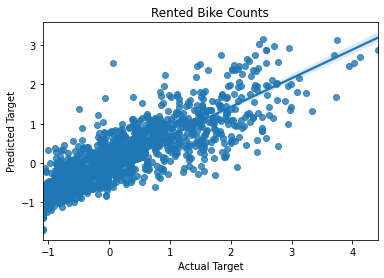

In [26]:
sns.regplot(x=y3_test, y=y1_pred)
plt.title('Rented Bike Counts')
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.show()

# CatBoost with Bayesian Optimization
1. Import Libraries

In [41]:
import sys
sys.path.append('/Users/elinorvelasquez/anaconda3/lib/python3.8/site-packages/')
#!conda install -c conda-forge hyperopt
#import hyperopt
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score
import catboost as cgb
#from hyperopt import hp, tpe, fmin

2. Data

In [42]:
X_cat = X_train
print(X_cat)
print(X_cat.shape)

y_cat = np.asarray(y_train, dtype='float')
print(y_cat)
print(y_cat.shape)

[[ 1.59657685  0.02237011  0.13701177 ...  0.18708879 -0.22996655
   0.22996655]
 [ 0.26270369  0.83822207  1.35998213 ...  0.18708879 -0.22996655
   0.22996655]
 [ 1.58865364 -0.14584679 -0.59677044 ...  0.18708879 -0.22996655
   0.22996655]
 ...
 [ 0.39779449  1.39333784  0.18593058 ...  0.18708879 -0.22996655
   0.22996655]
 [-1.39641743 -1.37383015 -0.35217637 ...  0.18708879 -0.22996655
   0.22996655]
 [ 1.14257666  0.53543165 -0.15650112 ...  0.18708879 -0.22996655
   0.22996655]]
(7008, 13)
[[ 0.45009077]
 [ 0.7602499 ]
 [ 1.15260119]
 ...
 [ 0.45629395]
 [-0.59359469]
 [ 1.23479336]]
(7008, 1)


3. A Trivial Example

In [29]:
# Define objective function
def simple_fx(x, y, z ):
    return -x ** 2 - (y - 1) -z** 2 + 1

In [30]:
# Search Space
pds = {'x': (1, 4), 'y': (-3, 3), 'z': (1,6)}

In [31]:
# optimization function and optimization
optimizer = BayesianOptimization(f=simple_fx,
                                 pbounds=pds,
                                 random_state=1)
optimizer.maximize(init_points=3,n_iter=10)

|   iter    |  target   |     x     |     y     |     z     |
-------------------------------------------------------------
|  1        | -5.39     |  2.251    |  1.322    |  1.001    |
|  2        | -1.654    |  1.907    | -2.119    |  1.462    |
|  3        | -8.406    |  1.559    | -0.9266   |  2.984    |
|  4        | -28.0     |  2.128    |  1.739    |  4.872    |
|  5        | -12.0     |  4.0      | -3.0      |  1.0      |
|  6        | -0.1327   |  1.183    | -0.4254   |  1.076    |
|  7        |  3.0      |  1.0      | -3.0      |  1.0      |
|  8        | -29.39    |  1.012    | -2.998    |  5.776    |
|  9        | -3.085    |  1.025    |  2.818    |  1.103    |
|  10       | -18.0     |  4.0      |  3.0      |  1.0      |
|  11       |  1.955    |  1.0      | -1.955    |  1.0      |
|  12       |  0.5482   |  1.0      | -3.0      |  1.858    |
|  13       | -1.083    |  1.0      |  1.083    |  1.0      |


In [32]:
# Check best results
optimizer.max

{'target': 3.0, 'params': {'x': 1.0, 'y': -3.0, 'z': 1.0}}

In [33]:
#Get search history
optimizer.res

[{'target': -5.390389235737196,
  'params': {'x': 2.251066014107722,
   'y': 1.3219469606529488,
   'z': 1.0005718740867244}},
 {'target': -1.653721990746281,
  'params': {'x': 1.9069977178955193,
   'y': -2.119464655097322,
   'z': 1.461692973843989}},
 {'target': -8.406446885097736,
  'params': {'x': 1.5587806341330128,
   'y': -0.9266356377417138,
   'z': 2.9838373711533497}},
 {'target': -28.00428654613743,
  'params': {'x': 2.1275211422930003,
   'y': 1.7392712101561543,
   'z': 4.872234510476437}},
 {'target': -12.0, 'params': {'x': 4.0, 'y': -3.0, 'z': 1.0}},
 {'target': -0.13266697297097063,
  'params': {'x': 1.183458255637944,
   'y': -0.4254053801474855,
   'z': 1.0758712331319444}},
 {'target': 3.0, 'params': {'x': 1.0, 'y': -3.0, 'z': 1.0}},
 {'target': -29.393300079757783,
  'params': {'x': 1.0121794799757575,
   'y': -2.998407684646069,
   'z': 5.776434926900835}},
 {'target': -3.0845381753525336,
  'params': {'x': 1.0248425740676093,
   'y': 2.8178983551824937,
   'z': 1

4. CatBoost has an internal cross-validation:

In [34]:
cat_features = []

cv_dataset = cgb.Pool(data=X_cat,
                  label=y_cat,
                  cat_features=cat_features) # X_cat = X_train, y_cat = y_train

In [51]:
def hyp_cat(depth, bagging_temperature):
    params = {"iterations": 300,
              "learning_rate": 0.05,
              "eval_metric": "R2",
              "loss_function": "RMSE",
              "verbose": False}
    params[ "depth"] = int(round(depth))
    params["bagging_temperature"] = bagging_temperature

    scores = cgb.cv(cv_dataset,
                params,
                fold_count=10)
    return np.max(scores['test-R2-mean'])

In [52]:
pds = {'depth': (6, 10),
          'bagging_temperature': (1,5),
          }

In [53]:
# Surrogate model
optimizer = BayesianOptimization(hyp_cat, pds, random_state=100)
                                  
# Optimize
optimizer.maximize(init_points=3, n_iter=7)

|   iter    |  target   | baggin... |   depth   |
-------------------------------------------------
|  1        |  0.7433   |  3.174    |  7.113    |
|  2        |  0.7571   |  2.698    |  9.379    |
|  3        |  0.7357   |  1.019    |  6.486    |
|  4        |  0.7625   |  2.818    |  9.866    |
|  5        |  0.7625   |  4.809    |  10.0     |
|  6        |  0.7625   |  1.0      |  10.0     |
|  7        |  0.7357   |  5.0      |  6.0      |
|  8        |  0.7625   |  3.82     |  10.0     |
|  9        |  0.7625   |  1.914    |  10.0     |
|  10       |  0.7571   |  5.0      |  9.06     |


In [54]:
optimizer.max

{'target': 0.7625068717754447,
 'params': {'bagging_temperature': 2.8182172285978595,
  'depth': 9.866160664560683}}